In [1]:
# General 2D entropic-OT MK ranks with barycentric projection.
# - Works for any 2D point cloud X (n x 2).
# - Pushes X to a quasi-uniform grid on the unit disk using entropic OT (Sinkhorn, log-domain).
# - Returns mapped points on the ball and scalar MK ranks (radii ρ in [0,1]).
# - Produces two figures: (1) original data colored by ρ; (2) mapped ball points colored by ρ.

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

# ------------------------- Utilities -------------------------

def unit_disk_grid(n: int) -> np.ndarray:
    """Quasi-uniform grid on the unit disk via golden-angle spiral with equal-area radii."""
    phi = (1 + 5**0.5) / 2
    idx = np.arange(1, n + 1)
    r = np.sqrt(idx / (n + 1.0))
    theta = 2 * np.pi * idx / (phi**2)
    return np.column_stack([r * np.cos(theta), r * np.sin(theta)])

def cdist2(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """Squared Euclidean distance matrix between row-sets A and B."""
    A2 = np.sum(A**2, axis=1)[:, None]
    B2 = np.sum(B**2, axis=1)[None, :]
    return A2 + B2 - 2 * A @ B.T

def logsumexp(M, axis=None):
    """Stable log-sum-exp along axis."""
    m = np.max(M, axis=axis, keepdims=True)
    s = np.log(np.sum(np.exp(M - m), axis=axis, keepdims=True)) + m
    return np.squeeze(s, axis=axis)

def sinkhorn_log_balanced(a, b, C, eps=0.2, max_iters=2000, tol=1e-9):
    """
    Log-domain balanced Sinkhorn with potentials f (rows) and g (cols).
    Returns the transport plan P.
    """
    n, m = C.shape
    f = np.zeros(n)
    g = np.zeros(m)
    log_a = np.log(a + 1e-300)
    log_b = np.log(b + 1e-300)

    for _ in range(max_iters):
        f_prev = f.copy()
        # Update f
        M_row = (f[:, None] + g[None, :] - C) / max(eps, 1e-12)
        f = f + eps * (log_a - logsumexp(M_row, axis=1))
        # Update g
        M_col = (f[:, None] + g[None, :] - C) / max(eps, 1e-12)
        g = g + eps * (log_b - logsumexp(M_col, axis=0))
        if np.max(np.abs(f - f_prev)) < tol:
            break

    # Transport plan
    P = np.exp((f[:, None] + g[None, :] - C) / max(eps, 1e-12))
    return P

def barycentric_projection(P, Y):
    """Row-wise barycentric projection of a plan onto target points Y."""
    rowsum = P.sum(axis=1, keepdims=True) + 1e-12
    return (P @ Y) / rowsum

def mk_ranks_entropic_2d(X, eps=0.2):
    """
    Given X (n x 2), compute entropic-OT MK ranks:
    - Build unit-disk grid Y of size n
    - Solve Sinkhorn and get plan P
    - Barycentric projection U_hat = (P Y) / (P 1)
    - MK rank radius ρ = ||U_hat|| in [0,1]
    Returns: rho (n,), U_hat (n,2), Y (n,2), P (n,n)
    """
    n = X.shape[0]
    Y = unit_disk_grid(n)
    a = np.ones(n) / n
    b = np.ones(n) / n
    C = cdist2(X, Y)
    P = sinkhorn_log_balanced(a, b, C, eps=eps)
    U_hat = barycentric_projection(P, Y)
    rho = np.linalg.norm(U_hat, axis=1)
    return rho, U_hat, Y, P

def set_equal_with_padding(ax, X, pad_frac=0.05):
    x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
    y_min, y_max = np.min(X[:,1]), np.max(X[:,1])
    dx = x_max - x_min; dy = y_max - y_min
    if dx <= 1e-12 and dy <= 1e-12: dx = dy = 1.0
    if dx <= 1e-12: dx = max(1e-3, 0.1 * dy)
    if dy <= 1e-12: dy = max(1e-3, 0.1 * dx)
    ax.set_xlim(x_min - pad_frac*dx, x_max + pad_frac*dx)
    ax.set_ylim(y_min - pad_frac*dy, y_max + pad_frac*dy)
    ax.set_aspect('equal', adjustable='box')

In [2]:
# ------------------------- Example usage -------------------------
# You can replace X here with your own (n x 2) numpy array.

n = 120

X = np.empty((n, 2))

# X[:n//2]   = rng.normal([0.35, 0.05], [0.15, 0.10], size=(n//2, 2))
# X[n//2:90] = rng.normal([-0.2, 0.25], [0.12, 0.20], size=(90 - n//2, 2))
# X[90:]     = rng.normal([0.7, -0.6], [0.05, 0.05], size=(n - 90, 2))  # a small outlier cluster

t = np.linspace(-1, 1, n)  # parameter along the line
X = np.column_stack([t, t])  # points on the line x=y
# X = np.column_stack([t, np.zeros(n)])  # points on the line x=y

In [3]:
# Compute ranks
eps = 0.25  # try 0.05..0.8; larger = smoother, smaller = crisper
rho, U_hat, Y, P = mk_ranks_entropic_2d(X, eps=eps)

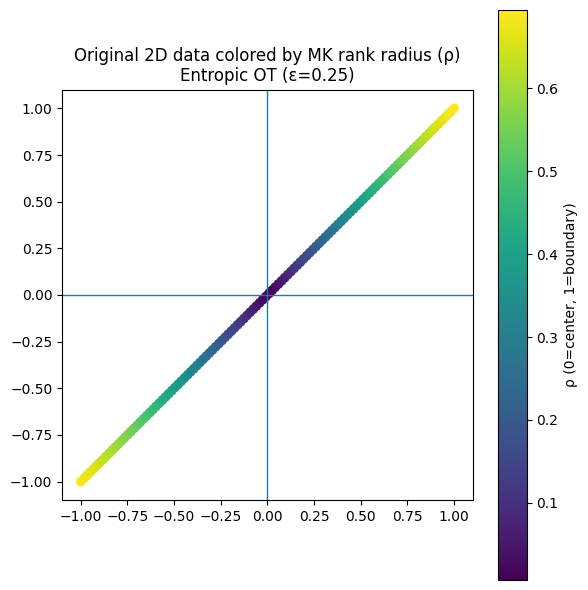

In [4]:
# ------------------------- Plots -------------------------

# 1) Original data colored by MK rank radius ρ
plt.figure(figsize=(6, 6))
sc = plt.scatter(X[:, 0], X[:, 1], c=rho)
plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
set_equal_with_padding(plt.gca(), X)
plt.title(f"Original 2D data colored by MK rank radius (ρ)\nEntropic OT (ε={eps})")
cbar = plt.colorbar(sc); cbar.set_label("ρ (0=center, 1=boundary)")
plt.tight_layout()
# plt.savefig('/mnt/data/general2d_rank_on_data.png', dpi=150)
plt.show()

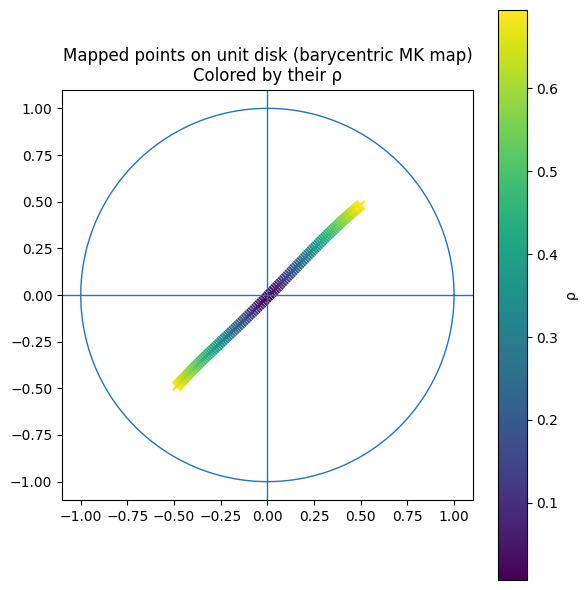

In [5]:
# 2) Barycentric images on the unit disk, colored by the same ρ
theta = np.linspace(0, 2*np.pi, 400)
plt.figure(figsize=(6, 6))
plt.plot(np.cos(theta), np.sin(theta), linewidth=1)  # unit circle
sc = plt.scatter(U_hat[:, 0], U_hat[:, 1], c=rho, marker='x')
plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
set_equal_with_padding(plt.gca(), np.vstack([U_hat, np.column_stack([np.cos(theta), np.sin(theta)])]))
plt.title("Mapped points on unit disk (barycentric MK map)\nColored by their ρ")
cbar = plt.colorbar(sc); cbar.set_label("ρ")
plt.tight_layout()
# plt.savefig('/mnt/data/general2d_rank_on_ball.png', dpi=150)
plt.show()

# print("Saved:")
# print(" - /mnt/data/general2d_rank_on_data.png")
# print(" - /mnt/data/general2d_rank_on_ball.png")